### On ML from scratch exercise, we see how to build a sequential and layer model. Here our focus is to refactor it to better extendability with clean seperation of concern which  makes it very easy to write simple networks that consist of layers layered on top of each other . 

#### Later after building the layer and sequential model , let discuss and implement the SGD and later in course will discuss about various optimizers

In [38]:
import numpy as np
import math
import copy
import ipdb as pdb

In [39]:
import progressbar
from terminaltables import AsciiTable

class Sequential:
    """ Accepts 
    layers - the set of layer layered on top of each other
    optimizer - A function which gives the estimate of the gradient which need to be updated to weights to minimize cost functions
    loss - the function which evalutes the performance of the model. How the predicted outcome is different from actual outcome. 
           in short we can call this as error rate"""
    def __init__(self, layers, optimizer, loss, nfeatures):
        self.layers, self.optimizer, self.loss = layers, optimizer, loss        
        self.progressbar = progressbar.ProgressBar()
            
        for i in range(0,len(self.layers)):              
            self.layers[i].set_inputshape(nfeatures if i == 0 else int(self.layers[i-1].outputshape()))
            
            #if setup method is there then call setup 
            if hasattr(self.layers[i], 'setup'):
                self.layers[i].setup(optimizer = self.optimizer,loss=self.loss)            

    
    """ Iterate through number of epoch on each batch, forward propagate and calculate the loss_gradient from output
        and propagates the gradient backwards  """ 
    def fit(self, X, y, Xvalid = None, yvalid=None, epochs= 100, batchsize= 64):
        
        for index in self.progressbar(range(epochs)):
            batchloss = []
            loss,auc,predictions=None, None, None
            for X_batch, y_batch in batchnext(X,y,batchsize = batchsize):
                loss,auc,predictions = self._train(X_batch,y_batch)
                batchloss.append(loss)
            #print(f'Epoch# {index} Training Loss:{loss}  Training Accuracy:{auc}')
                
                
            if (index % 1000 == 0 and Xvalid is not None and yvalid is not None):
                mloss = np.mean(batchloss)
                val_loss, val_auc,_ = self.predict(Xvalid,yvalid)
                print(f'Epoch# {index} Training Loss:{loss} Validation Loss: {val_loss} Training Accuracy:{auc} Validation Accuracy:{val_auc}') 
            elif(index % 1000 == 0):
                print(f'Epoch# {index} Training Loss:{loss}  Training Accuracy:{auc}')
                print(predictions)
                
        
    """Predicting outcome mainly for validation or test set"""
    def predict(self, X, y):
        y_pred = self._forward(X)  
        loss = self.loss(y, y_pred)
        accuracy = self.loss.auc(y, y_pred)
        return loss, accuracy,y_pred
    
    """ Training on single batch with gradient updates"""
    def _train(self, X, y):        
        y_pred = self._forward(X)        
        loss = self.loss(y, y_pred, self._layerweights())
        accuracy = self.loss.auc(y,y_pred)
        grad = self.loss.gradient(y, y_pred)        
        self._backward(grad)
        #self._step()
        return loss, accuracy,y_pred        
        
    
    #calculate the output by propagating forward
    def _forward(self, X, training=True):
        layerout= X
        for layer in self.layers:
            #if(hasattr(layer, 'w')):
            #    print(layer.w)
            layerout = layer.forward(layerout,training)     
            
        return layerout
    
    def _layerweights(self):
        layerweigths = []
        for layer in self.layers:
            if hasattr(layer, 'w'):
                layerweigths.append(layer.w)
        return layerweigths 
        
    
    #Propagate the gradient backwards and update the weights in each layer
    def _backward(self, grad):
        for layer in reversed(self.layers):
            grad= layer.backward(grad)
            
        return grad
    
    def _step(self):
        for layer in reversed(self.layers):
            if hasattr(layer, 'step'):
                layer.step()
            
       
            
    def summary(self , title = "Model Summary"):
        print (AsciiTable([[title]]).table)
        print ("Input Shape: %s" % str(self.layers[0].inputshape))
        
        table_data = [["Layer Name", "Input Shape", "Output Shape" , "Shape"]]
        for layer in self.layers:
            table_data.append([layer.name, layer.inputshape, layer.outputshape(), layer.shape])
            
        print (AsciiTable(table_data).table)    
        

### A simple iterator which yields input as batch based on its batchsize

In [40]:
def batchnext(X,y,batchsize =64):
    nSize= X.shape[0]
    for b in np.arange(0, nSize, batchsize):
        start, end = b , min(nSize, b+batchsize)
        yield X[start:end], y[start:end]

In [41]:
def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

## Abstract/base Layer Class

In [42]:
class Layer(object):
    def __init__(self):
        pass
    
    @property
    def name(self):
        """ returns the name of the layer and mainly for displaying model summary."""
        return self.__class__.__name__
    
    @property
    def shape(self):
        raise NotImplementedError()       
    
    def outputshape(self):
        raise NotImplementedError()   
    
    def set_inputshape(self, shape):      
        self.inputshape= shape
        
        
    def forward(self, X, training = True):
        raise NotImplementedError()
    
    def backward(self, grad):
        raise NotImplementedError()  
    

## Simple Linear Layer - Extending the base Layer class

In [43]:
class Dense(Layer):
    def __init__(self,nunits): 
        self.nunits = nunits
        self.input = None
        self.w, self.b = None, None
        
    def setup(self, optimizer,loss):
        self.loss = loss
        rangelimit = 1 / math.sqrt(self.inputshape)       
        self.w = np.random.uniform(-rangelimit,rangelimit,self.shape)  
        self.b = (rangelimit * np.random.random((1,self.nunits))) 
        self.w_opt = copy.copy(optimizer)
        self.b_opt = copy.copy(optimizer)       
        
    
    @property
    def shape(self):
        return (self.inputshape ,self.outputshape())
    
 
    def outputshape(self):
        return self.nunits
    
    def forward(self, X, training = True):        
        self.input = X
        return X.dot(self.w) + self.b
        
    def backward(self, grad):
        W = self.w
        
        self.dw = np.dot(self.input.T,grad)
        self.db = np.sum(grad, axis =0, keepdims=True) 
               
        grad = grad.dot(W.T)
        
        self.w =self.w_opt.update(self.w, self.dw)
        self.b = self.b_opt.update(self.b, self.db) 
        
        if hasattr(self.loss, 'reg'):
            self.dw += self.loss.reg *  self.w   
            
        return grad

## Activation Class - Simple Extension over Layer class

In [44]:
class Activation(Layer):
    def __init__(self, activationfn):
        self.activationfn = activationfn()
       
    @property
    def shape(self):
        return (self.inputshape ,self.outputshape())
    
    @property
    def name(self):
        """ returns the name of the layer and mainly for displaying model summary."""
        return self.activationfn.__class__.__name__
    
    
    def forward(self, X, training = True):
        
        self.input = X
        self.h = self.activationfn(X)
        return self.h
        
    
    def backward(self, grad):        
        activationgrad = self.activationfn.gradient(self.h)         
        if(activationgrad is None): return grad            
        return grad *   activationgrad   
    
   
    def outputshape(self):
        return self.inputshape    

In [58]:
#List of Activation functions

class sigmoid:
    def __call__(self,x):
        return 1/(1+np.exp(-x)) 
      
    
    def gradient(self,x):
        return (x * (1-x))
    

class relu:
    def __call__(self,x):
        return x * (x >0)
        #return np.where(x>=0, x , 0)
    
    def gradient(self,x):
        return 1. * (x >0)
        #return np.where(x>=0, 1 , 0)
    
    
class softmax:
    def __call__(self,x):
        expo = np.exp(x)
        result = expo/np.sum(expo,axis=1, keepdims=True)  
        return result
    
    def gradient(self,x):
        return None

## A abstract loss class with helps in evaluating the loss value between the predicted and actual

In [46]:
#Loss Function
class Loss(object):
    def __call__(self, y, p,lweights = None):
        pass   

        
    def auc(self, y, p):
        return accuracy_score(y,p)
    
    def gradient(self, y, p):
        raise NotImplementedError()
    

class CrossEntropy(Loss):
    
    def __init__(self, reg=1e-3):
        self.reg = reg
        
    def __call__(self, y, p,lweights = None):
        return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))    
    
    def auc(self, y, p):
        #print( np.argmax(p, axis=1))
        return accuracy_score(y.ravel(), np.argmax(p, axis=1))
        
   
    def gradient(self, y, p):
        return y - p 
    
class CrossEntropyForSoftMax(Loss):
    
    def __init__(self, reg=1e-3):
        self.reg = reg
    
    def __call__(self, y, p,lweights = None):
        #select the right propbolity for loss  
        correct_prob = -np.log(p[range(len(y)), y.ravel()-1])
        dataloss = np.sum(correct_prob)/len(y)       
        #regularization can be defined by 1/2 * Reg * np.sum(w*2)
        regloss= 0
    
        if lweights is not None:
            for weight in lweights:
                regloss +=  0.5* self.reg* np.sum(np.square(weight))
        
        return dataloss+regloss   
    
    def auc(self, y, p):
        #print( np.argmax(p, axis=1))
        return accuracy_score(y.ravel(), np.argmax(p, axis=1)+1)
        
   
    def gradient(self, y, p):
        dscore = p
        dscore[range(len(y)), y.ravel()-1] -= 1        
        dscore /= len(y)
        return dscore     
    

### Optimizer is a technique which produces gradients iteratively to update weights in order to minimize the cost function or converge to local minima. The traditional Gradient Desent(bacth) requires all the training sampled to be loaded into the memory to calculate the gradients. This is in a real world, seems to be not effective and sometimes not pratical too,  since usually the dataset is bigger in size. To address this issue, instead of loading the Data as a whole, load it in batches and calculuate gradient at batch levelwith same level of accuracy. This is named as SGD - Stochastic Gradient Desent

In [47]:
class SGD:
    def __init__(self, learning_rate = 0.01, momentum=0):
        self.learning_rate = learning_rate 
        self.momentum = momentum
        self.w_updated = None
    
    def update(self, w, grad):
        if self.w_updated is None:
            self.w_updated = np.zeros(np.shape(w))        
        
        #use the momentum if any
        self.w_updated = (self.momentum * self.w_updated) + (1-self.momentum) * grad        
        return w - (self.learning_rate * grad) 


In [48]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [49]:
data = loadmat("data\handwritten.mat")
print(data['X'].shape)
print(data['y'].shape)

(5000, 400)
(5000, 1)


In [50]:
def show(img, title:None):
    plt.imshow(img, cmap='gray')
    if(title is not None): plt.title(title)

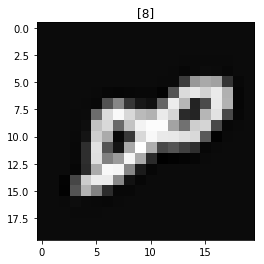

In [51]:
#reshape by 20*20
image = np.reshape(data['X'][4000],(20,20))
image.shape
show(image, data['y'][4000])

In [52]:
X = data['X']
y =  data['y']

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(
            X,y, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_valid.shape)

(4000, 400)
(1000, 400)


In [54]:
optimizer = SGD(learning_rate =  0.1,momentum=0.9)
loss = CrossEntropyForSoftMax()

In [55]:
model = Sequential([    
    Dense(100),
    Activation(relu),    
    Dense(10),
    Activation(softmax)    
],  optimizer, loss, X.shape[1])



In [56]:
model.fit(X_train,y_train,X_valid,y_valid,epochs= 10000,batchsize= 5000)

  0% (4 of 10000) |                       | Elapsed Time: 0:00:00 ETA:  0:10:39

Epoch# 0 Training Loss:2.3403229024928573 Validation Loss: 2.3074124730034136 Training Accuracy:0.0945 Validation Accuracy:0.113


 10% (1005 of 10000) |##                  | Elapsed Time: 0:00:51 ETA:  0:07:38

Epoch# 1000 Training Loss:0.265501929056545 Validation Loss: 0.33293805906750074 Training Accuracy:0.94525 Validation Accuracy:0.913


 20% (2004 of 10000) |####                | Elapsed Time: 0:01:45 ETA:  0:06:34

Epoch# 2000 Training Loss:0.2077465428677755 Validation Loss: 0.307015676711618 Training Accuracy:0.97025 Validation Accuracy:0.924


 30% (3003 of 10000) |######              | Elapsed Time: 0:02:30 ETA:  0:05:13

Epoch# 3000 Training Loss:0.18037721176037894 Validation Loss: 0.2957282513857925 Training Accuracy:0.981 Validation Accuracy:0.927


 40% (4004 of 10000) |########            | Elapsed Time: 0:03:14 ETA:  0:04:23

Epoch# 4000 Training Loss:0.16830148054695862 Validation Loss: 0.29458238505657175 Training Accuracy:0.99025 Validation Accuracy:0.929


 50% (5004 of 10000) |##########          | Elapsed Time: 0:04:07 ETA:  0:04:10

Epoch# 5000 Training Loss:0.1654000325474913 Validation Loss: 0.29805013375393397 Training Accuracy:0.99575 Validation Accuracy:0.934


 60% (6005 of 10000) |############        | Elapsed Time: 0:04:59 ETA:  0:03:22

Epoch# 6000 Training Loss:0.16722798929517077 Validation Loss: 0.30464483799744313 Training Accuracy:0.99825 Validation Accuracy:0.934


 70% (7004 of 10000) |##############      | Elapsed Time: 0:05:47 ETA:  0:02:24

Epoch# 7000 Training Loss:0.17126566155588857 Validation Loss: 0.31207865133132734 Training Accuracy:0.9995 Validation Accuracy:0.934


 80% (8003 of 10000) |################    | Elapsed Time: 0:06:37 ETA:  0:01:39

Epoch# 8000 Training Loss:0.176136726107794 Validation Loss: 0.31906940997525635 Training Accuracy:0.99975 Validation Accuracy:0.935


 90% (9004 of 10000) |##################  | Elapsed Time: 0:07:25 ETA:  0:00:47

Epoch# 9000 Training Loss:0.18116820783995924 Validation Loss: 0.3254068859103843 Training Accuracy:1.0 Validation Accuracy:0.935


100% (10000 of 10000) |###################| Elapsed Time: 0:08:14 Time: 0:08:14


In [57]:
model.summary()

+---------------+
| Model Summary |
+---------------+
Input Shape: 400
+------------+-------------+--------------+------------+
| Layer Name | Input Shape | Output Shape | Shape      |
+------------+-------------+--------------+------------+
| Dense      | 400         | 100          | (400, 100) |
| relu       | 100         | 100          | (100, 100) |
| Dense      | 100         | 10           | (100, 10)  |
| softmax    | 10          | 10           | (10, 10)   |
+------------+-------------+--------------+------------+
